# Algoritmus 2D Szenzor optimális pozíciójára

Vegyünk egy 2D hőtérképet kiindulásképpen.

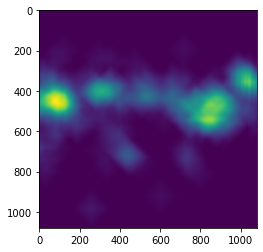

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from place_me import run_v2 as optimize

data = np.loadtxt('data/heatmap2.txt')
data = 255 * data / data.max()
data = data[:, 2760:3840]
plt.imshow(data);

A hőtérképen kiválasztunk $n$ darab lokális maximum helyet, amelyen elhelyezünk $R$ sugarú köröket, ahol $n$ és $R$ az adott környezethez választott. (Példa: $n$-t az alkalmazást használó személyek számából kapjuk, $R$-t pedig úgy választjuk, hogy a valóságbeli mérete nagyjából az emberi kézzel azonos legyen). A hőtérkép nem determinisztikus, hanem valószínűségi jellegű, vagyis a generált körök pontos pozíciója ingadozik: a hőtérképen nagyobb értéken nagyobb valószínűséggel tartózkodik. A körök nem fedhetnek egymásba. Az alábbi kép egy $n = 4$ és $R = 50\,pixel$ felállást mutat.

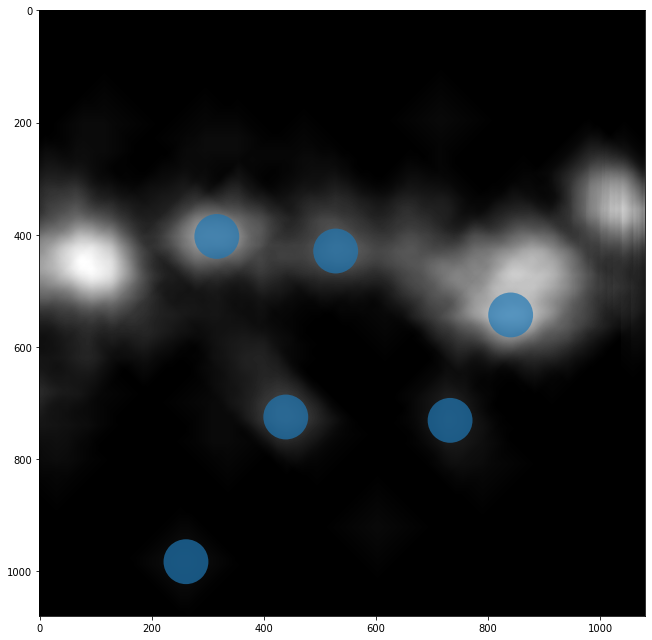

In [12]:
CIRCLE_RADIUS = 40

image_max = ndi.maximum_filter(data, size=20, mode='constant')

peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=6)

def plot_from_optimal_coords(data, peaks, arr=None):
    fig, ax = plt.subplots(figsize=(10, 9))
    ax.imshow(data, cmap=plt.cm.gray)
    ax.autoscale(False)
    if arr is not None:
        [x1, y1, x2, y2] = arr
        ax.plot(x1, y1, 'yx', markersize=25, markeredgewidth=3)
        ax.plot(x2, y2, 'rx', markersize=25, markeredgewidth=3)

    for y, x in peaks:
        circ = Circle((x, y), CIRCLE_RADIUS, alpha=0.7)
        ax.add_patch(circ)

    fig.tight_layout()

    plt.show()

plot_from_optimal_coords(data, peaks)

Minden szenzor a hőtérkép kerülete mentén mozoghat. Egy szenzor esetén a lefedettséget úgy definiáljuk, hogy:
  - a lehető legtöbb kört lássuk
  - a körökből látott kerület szeletek összege a lehető legnagyobb


Újabb szenzorok hozzáadásánál egy adott körnél a már korábban lefedett területeket nem vesszük figyelembe - mivel ez nem hordoz új információt. A folyamat az, hogy addig adunk hozzá új szenzorokat, amíg minden kör látható legalább egy szenzor számára. A valószínűségi jelleg miatt ezt a szimulációt kellően sokszor futtatva megkapjuk, hogy mik lesznek az optimális szenzor pozíciók.

Legyen $L(x) = 1$ ha $x > 0$, különben $0$, ún. "lépcsőfüggvény", továbbá legyen egy adott $i$ objektum belátott része $L_{i} = \frac{\sum látott\,kerület}{2\pi R}$. Ekkor $n$ darab objektum esetén az $LF$ teljes lefedettséget a következőképpen definiáljuk:
<center>
$LF = \sum_{i=1}^{n} (L(x_i) + L_i(x))$
</center>



A lentebbi ábra ezzel a súlyfüggvénnyel számolt szimuláció esetét mutatja, ahol piros és sárga markerek mutatják az optimális szenzor pozíciókat.


env: RUST_LOG=0


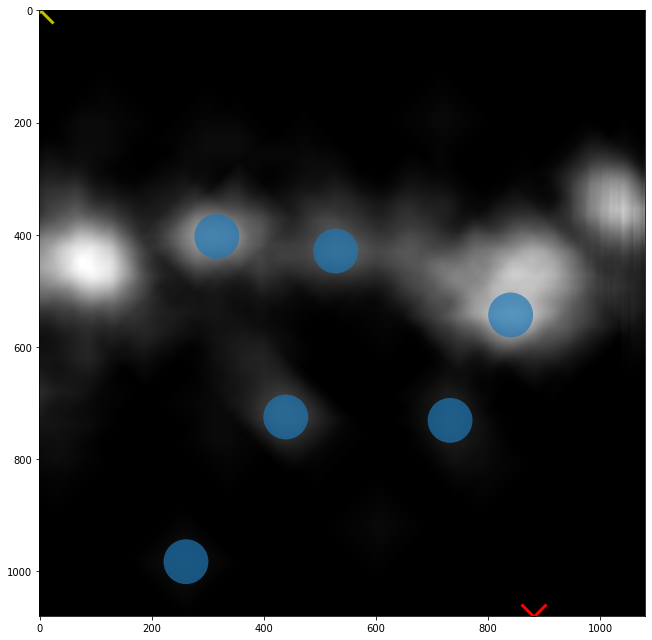

In [15]:
%env RUST_LOG=0

arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
options = {
    'width': data.shape[1],
    'height': data.shape[0],
    'resolution': 2880,
    'pixel_step': 10,
}
result = optimize(*arr.T, **options)
plot_from_optimal_coords(data, peaks, result)

### Részletek

Legyen egy $r$ sugarú kör $O(O_x, O_y)$ középponttal, továbbá tekintsünk két $P(P_x, P_y)$ pontból kiinduló sugarat, amelyek $P_1(P_{1x}, P_{1y})$ és $P_2(P_{2x}, P_{2y})$ pontokban metszik a kört (ha több metszéspont is lehetséges, akkor a közelebbit választjuk). Legyen a metszéspontoknál lévő két szög $\alpha_1$ és $\alpha_2$ standard x-y koordinátarendszerben, amelyek egyszerűen számolhatóak az $atan2(P_{iy} - O_y, P_{ix} - O_x)$ formulával. 

A szimuláció során minden körhöz hozzá van rendelve egy állapot, amely tárolja, hogy mely szögtartományokban van lefedve. Ezek összefedő részei egy adott szenzorállásnál egyesítésre kerülnek, aztán a fennmaradó intervallumok hosszát kiszámolva, majd $2\pi$-vel elosztva megkapjuk, hogy az adott kör hányad része lefedett, vagyis ez adja a fentebb említett $L_i(x)$ függvényt.